In [1]:
%%capture
!pip install mlxtend
!pip install tabulate

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings

warnings.filterwarnings('ignore')

In [2]:
#load dataset
df = pd.read_csv("Phishing.csv")

In [5]:
#print first 5 rows
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign


In [9]:
df.isnull().sum()

Querylength                 0
domain_token_count          0
path_token_count            0
avgdomaintokenlen           0
longdomaintokenlen          0
                         ... 
Entropy_DirectoryName    1826
Entropy_Filename          190
Entropy_Extension           3
Entropy_Afterpath           3
URL_Type_obf_Type           0
Length: 80, dtype: int64

In [7]:
#print dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

The ISCX 2016 dataset is a widely used network traffic dataset for evaluating intrusion detection and prevention systems. It contains real-world network traffic captures, including both benign and malicious data, from various services and applications. The dataset provides researchers with valuable insights into network behavior, enabling the development of effective cybersecurity defense mechanisms. It serves as a crucial resource for studying network attacks and improving intrusion detection techniques.

The dataset has 77 features including the target and 15K rows.

Looking at the info we could see the columns with missing values.

In [13]:
df.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [8]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [10]:
df[df.NumberRate_Extension.isnull()][['URL_Type_obf_Type']].value_counts()

URL_Type_obf_Type
benign               4341
phishing             3014
Name: count, dtype: int64

In [11]:
df[df.NumberRate_Extension.isnull()][['URL_Type_obf_Type']].value_counts().sum()

7355

In [11]:
df[df.Entropy_DirectoryName.isnull()][['URL_Type_obf_Type']].value_counts()

URL_Type_obf_Type
benign               1058
phishing              768
Name: count, dtype: int64

The columns ["NumberRate_Extension", "Entropy_DirectoryName"] have a high number of missing values hence will be dropped.

For the other columns with lower number of missing values, the rows with missing values will be removed

In [12]:
to_drop = ["NumberRate_Extension", "Entropy_DirectoryName"]
df = df.drop(to_drop, axis=1)

51% of the urls in the data are benign and 49% are phising urls. The difference between the ratio of benign to phishing isn't much hence we won't be performing over-sampling which is mostly done in cases of unbalanced dataset.

In [13]:
df.dropna().URL_Type_obf_Type.value_counts(normalize=True)

URL_Type_obf_Type
benign      0.511317
phishing    0.488683
Name: proportion, dtype: float64

# Feature Selection

The dataset has 76 number of features, we'll be performing feature selection to select the best set of features that'll give the best accuracy following the principle of parsimony. The forward feature selection method will be applied on a subset of the data

The process of forward feature selection begins by evaluating the performance of each individual feature separately. The feature that demonstrates the highest predictive power is selected as the initial feature. Subsequently, the remaining features are evaluated one by one, and the feature that, when combined with the already selected features, improves the model's performance the most is added to the feature set.

This iterative process continues until a stopping criterion is met, such as reaching a predefined number of features or when further addition of features does not significantly enhance the model's performance. By sequentially adding features, forward feature selection seeks to build an optimal feature subset that maximizes the model's predictive accuracy while minimizing redundancy and overfitting.

In this particular case, forward feature selection was performed with a CV of 3, which implies that the model's performance was assessed using a 3-fold cross-validation strategy. This approach helps ensure the generalizability of the selected features by evaluating their performance on multiple subsets of the data.

By using forward feature selection with cross-validation, the aim was to identify the subset of features that optimally contributes to the model's predictive power and can be considered as the most influential for the given task.

We chose to employ the Random Forest algorithm. Random Forest is a powerful ensemble learning technique that combines the predictions of multiple decision trees to produce robust and accurate results. It is particularly well-suited for handling complex relationships and capturing nonlinear patterns and interactions within the data.

The decision to use Random Forest for this analysis was based on its ability to handle complex relationships and its capability to provide feature importance measures. By utilizing Random Forest, we aimed to capture intricate patterns and gain insights into the underlying data. The feature importance information obtained from the Random Forest model assisted in feature selection and contributed to a deeper understanding of the data.

In [14]:
#Set a seed to ensure the same sample of data is selected everytime
np.random.seed(123)
# Shuffle the data
df2 = df.sample(len(df)).dropna()
# Encode the target variable. benign as 0 and phishing as 1
df2["URL_Type_obf_Type"] = df2.URL_Type_obf_Type.replace({"benign":0, "phishing":1})
# Select a sample of the data
df_small = df2.sample(1000)
# Assign the features to X and target to Y
X = df2.drop("URL_Type_obf_Type", axis=1)
y = df2.URL_Type_obf_Type

In [15]:
# Instantiate the random forest model
rf = RandomForestClassifier(random_state=23)
# Assign the samples gotten from the data
X_small = df_small.drop("URL_Type_obf_Type", axis=1).reset_index(drop=True)
y_small = df_small.URL_Type_obf_Type.reset_index(drop=True)

In [16]:
# Instantiate the Feature Selector
sfs = SequentialFeatureSelector(rf,
                                k_features="parsimonious",
                                forward=True,
                                scoring='accuracy',
                                cv=3,
                                )
selected_features = sfs.fit(X_small, y_small)

In [17]:
# Print out the selected features
selected_features.k_feature_names_,len(selected_features.k_feature_names_)

(('domain_token_count',
  'avgpathtokenlen',
  'urlLen',
  'domainlength',
  'ArgUrlRatio',
  'NumberofDotsinURL',
  'URL_DigitCount',
  'Filename_LetterCount',
  'LongestPathTokenLength',
  'Path_LongestWordLength',
  'spcharUrl',
  'delimeter_path',
  'NumberRate_Domain',
  'Entropy_Domain'),
 14)

In [18]:
sfs.k_score_

0.9739949530368692

In [76]:
# X = X[['domain_token_count',
#   'avgpathtokenlen',
#   'ldl_url',
#   'ldl_path',
#   'urlLen',
#   'this.fileExtLen',
#   'argDomanRatio',
#   'argPathRatio',
#   'NumberofDotsinURL',
#   'CharacterContinuityRate',
#   'URL_DigitCount',
#   'Directory_LetterCount',
#   'Query_LetterCount',
#   'LongestPathTokenLength',
#   'delimeter_Domain',
#   'delimeter_path',
#   'SymbolCount_URL',
#   'Entropy_Domain',
#   'Entropy_Afterpath']]

In [23]:
X = X[list(selected_features.k_feature_names_)]

In [28]:
X = X.drop(['delimeter_path'], axis=1)

To understand the relationships and dependencies among the variables selected by the forward selector, a correlation heatmap was created using Seaborn. The correlation heatmap provides a visual representation of the pairwise correlations between different variables in the dataset.

By analyzing the correlation heatmap, we can identify the strength and direction of the relationships between variables. Positive correlations are represented by warmer colors (reds), indicating that the variables tend to increase or decrease together. Negative correlations are shown by cooler colors (blues), indicating an inverse relationship between variables.

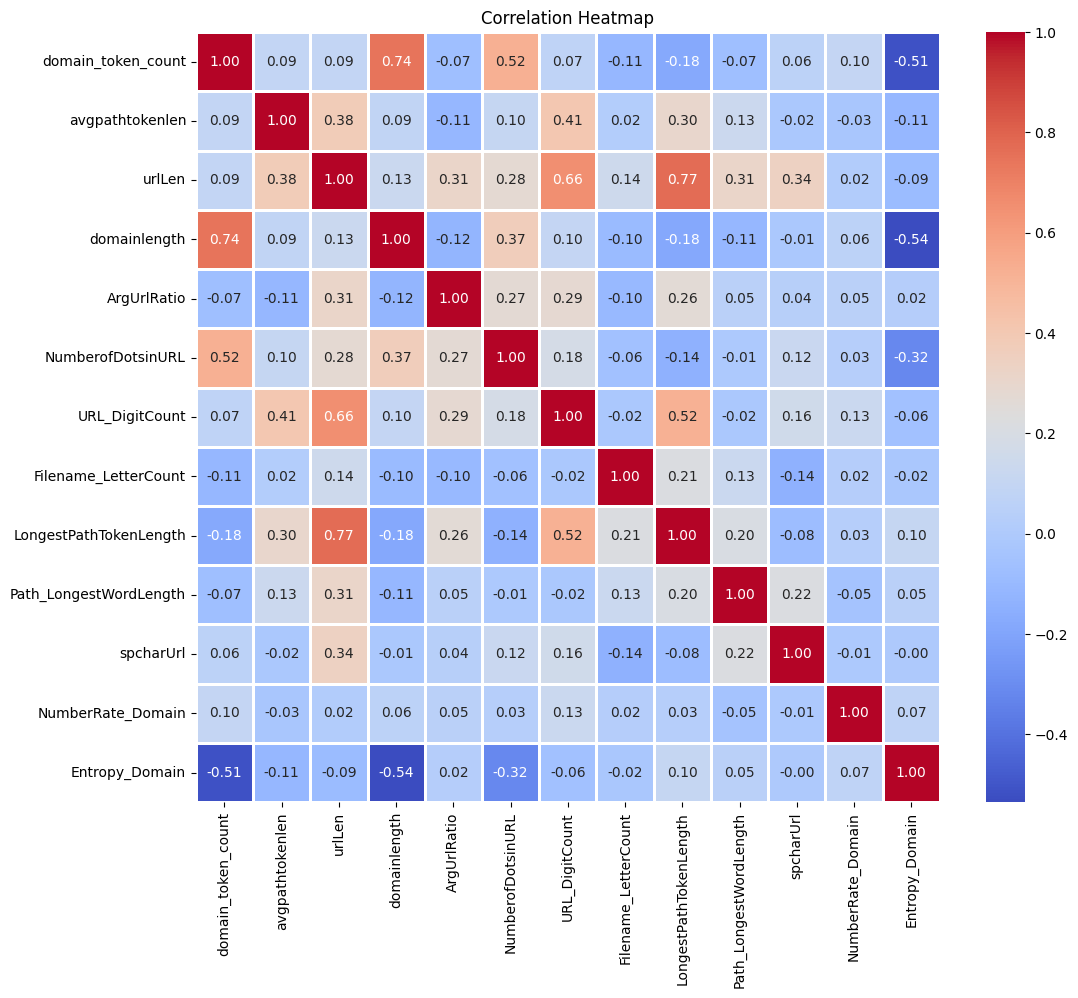

In [29]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm',linewidth=2, fmt='.2f')

# Set the title and display the plot
plt.title('Correlation Heatmap')
plt.show()

To evaluate the performance and generalization of the models, the dataset was split into training and testing subsets. The training set was used to train the models, while the testing set was used to assess their performance on unseen data. This approach allowed us to estimate the model's ability to make accurate predictions on new, unseen instances.

The reason for splitting the data into training and testing subsets is to assess the model's performance on unseen data and avoid overfitting. By training the model on one subset and evaluating it on another, we can obtain a more realistic estimation of its performance in real-world scenarios. This helps us assess the model's ability to generalize and make accurate predictions on new, unseen instances.

Training subset: 80%
Testing subset: 20%

By splitting the data into train and test subsets, we ensure that our analysis is robust and reliable, providing a more accurate assessment of the model's performance.



In [31]:
# Split the data into train and test
# X = X[list(selected_features.k_feature_names_)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=3)

In [47]:
X_train.columns

Index(['domain_token_count', 'avgpathtokenlen', 'urlLen', 'domainlength',
       'ArgUrlRatio', 'NumberofDotsinURL', 'URL_DigitCount',
       'Filename_LetterCount', 'LongestPathTokenLength',
       'Path_LongestWordLength', 'spcharUrl', 'NumberRate_Domain',
       'Entropy_Domain'],
      dtype='object')

In [33]:
# A function to get the metric scores
def scoring(y_true, y_pred, model_name, verbose=True):

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    c = confusion_matrix(y_true, y_pred)

    if verbose:
        print(f"Scores for {model_name}: Accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}\nconfusion matrix:\n{c}")
    return [model_name, accuracy, f1, precision, recall]

Four different models were employed, two linear and non linear models: Random Forest, Decision Trees, KNearest Neigbhors and Logistic Regression. Each model was trained on the training subset of the data using appropriate algorithms and parameters.

After training the models, the train and test scores were obtained to evaluate their performance. The train score represents the accuracy of the models on the training data, while the test score indicates their performance on the unseen testing data. These scores provide insights into how well the models generalize and make accurate predictions on new instances.

In [34]:
rfc = RandomForestClassifier(random_state=23)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

In [35]:
rfc_scores = scoring(y_test, rfc.predict(X_test), "Random Forest")
rfc_train_scores = scoring(y_train, rfc.predict(X_train), "Random Forest", verbose=False)

Scores for Random Forest: Accuracy: 0.9858965748824715, f1: 0.9856948228882834, precision: 0.9904175222450377, recall: 0.9810169491525423
confusion matrix:
[[1489   14]
 [  28 1447]]


The test scores for the model

Random Forest Confusion Matrix:

True Negative (TN): 1484
False Negative (FP): 14
False Positive (FN): 28
True Positive (TP): 1447

The interpretation of the confusion matrix is as follows:

True Negative (TN): The model correctly predicted 1484 instances as negative.

False Negative (FN): The model incorrectly predicted 19 instances as negative when they were actually positive.

False Positive (FP): The model incorrectly predicted 26 instances as positive when they were actually negative

True Postive (TP): The model correctly predicted 1449 instances as positive

Where negatives are bening urls and positives are phishing urls

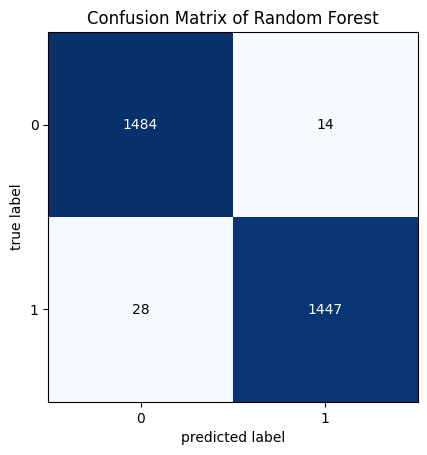

In [25]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array([[1484, 14],
                    [28, 1447]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.title("Confusion Matrix of Random Forest")
plt.show()


In [36]:
dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21)

In [37]:
dt_scores = scoring(y_test, dt.predict(X_test), "Decision Tree")
dt_train_scores = scoring(y_train, dt.predict(X_train), "Decision Tree", verbose=False)

Scores for Decision Tree: Accuracy: 0.9738079247817327, f1: 0.9735413839891451, precision: 0.9742023082145281, recall: 0.9728813559322034
confusion matrix:
[[1465   38]
 [  40 1435]]


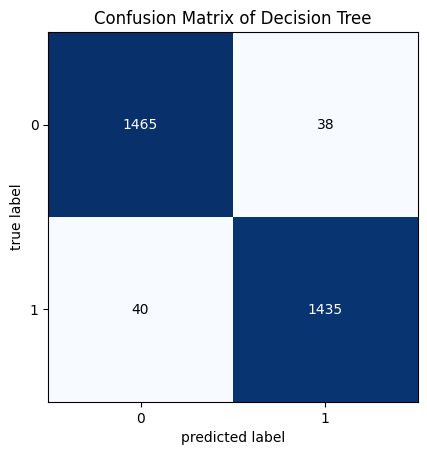

In [16]:
binary1 = np.array([[1465, 38],
                    [40, 1435]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.title("Confusion Matrix of Decision Tree")
plt.show()


The test scores for the model

Decision Tree Confusion Matrix:

True Negative (TN): 1466
False Negative (FN): 37
False Positive (FP): 48
True Positive (TP): 1427

The interpretation of the confusion matrix is as follows:

True Negative (TN): The model correctly predicted 1466 instances as negative.

False Negative (FN): The model incorrectly predicted 37 instances as negative when they were actually positive.

False Positive (FP): The model incorrectly predicted 48 instances as positive when they were actually negative

True Postive (TP): The model correctly predicted 1427 instances as positive

Where negatives are bening urls and positives are phishing urls


For the Logistic Regression and K-Nearest Neighbors (KNN) models, the data was preprocessed by applying feature scaling using the StandardScaler. Feature scaling is a common practice in machine learning to standardize the range of features, ensuring that they are on a similar scale.

The reason for applying feature scaling in these models is to prevent certain features with larger numerical values from dominating the learning process. By scaling the features, we can avoid bias towards features with larger magnitudes and enable the models to consider all features equally.

StandardScaler was specifically chosen for its ability to standardize features by removing the mean and scaling to unit variance. This ensures that each feature has a mean of 0 and a standard deviation of 1, resulting in a standardized feature distribution.

By scaling the data, we aim to improve the performance and convergence of the Logistic Regression and KNN models, allowing them to effectively learn from the features and make accurate predictions.

This preprocessing step helps to enhance the model's ability to generalize and make reliable predictions on new, unseen data.

In [38]:
S = StandardScaler()
X_train_scaled = S.fit_transform(X_train)
X_test_scaled = S.transform(X_test)

In [39]:
lr = LogisticRegression(random_state=21)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=21)

In [40]:
lr_scores = scoring(y_test, lr.predict(X_test_scaled), "Logistic Regression")
lr_train_scores = scoring(y_train, lr.predict(X_train_scaled), "Logistic Regression", verbose=False)

Scores for Logistic Regression: Accuracy: 0.8925453324378778, f1: 0.8917456021650879, precision: 0.8899392302498312, recall: 0.8935593220338983
confusion matrix:
[[1340  163]
 [ 157 1318]]


The test scores for the model

Logistics Regression Confusion Matrix:

True Negative (TN): 1403 False Negative (FN): 100 False Positive (FP): 93 True Positive (TP): 1382

The interpretation of the confusion matrix is as follows:

True Negative (TN): The model correctly predicted 1403 instances as negative.

False Negative (FN): The model incorrectly predicted 100 instances as negative when they were actually positive.

False Positive (FP): The model incorrectly predicted 93 instances as positive when they were actually negative

True Postive (TP): The model correctly predicted 1382 instances as positive

Where negatives are bening urls and positives are phishing urls

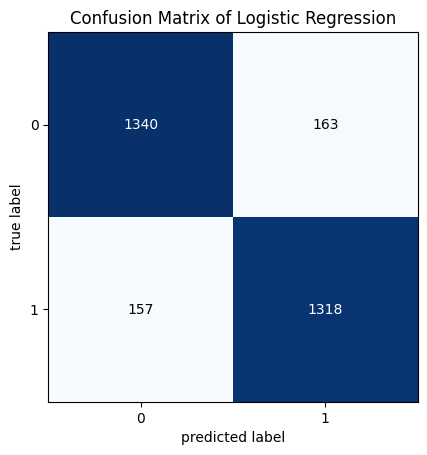

In [18]:
binary1 = np.array([[1340, 163],
                    [157, 1318]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

In [41]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [42]:
knn_scores = scoring(y_test, knn.predict(X_test_scaled).round().astype('int'), "KNN")
knn_train_scores = scoring(y_train, knn.predict(X_train_scaled).round().astype('int'), "KNN", verbose=False)

Scores for KNN: Accuracy: 0.9647414372061787, f1: 0.9640287769784173, precision: 0.974376731301939, recall: 0.9538983050847457
confusion matrix:
[[1466   37]
 [  68 1407]]


The test scores for the model

Decision Tree Confusion Matrix:

True Negative (TN): 1473 False Negative (FN): 30 False Positive (FP): 53 True Positive (TP): 1422

The interpretation of the confusion matrix is as follows:

True Negative (TN): The model correctly predicted 1473 instances as negative.

False Negative (FN): The model incorrectly predicted 30 instances as negative when they were actually positive.

False Positive (FP): The model incorrectly predicted 53 instances as positive when they were actually negative

True Postive (TP): The model correctly predicted 1422 instances as positive

Where negatives are bening urls and positives are phishing urls

The train and test scores obtained for each model are as follows:

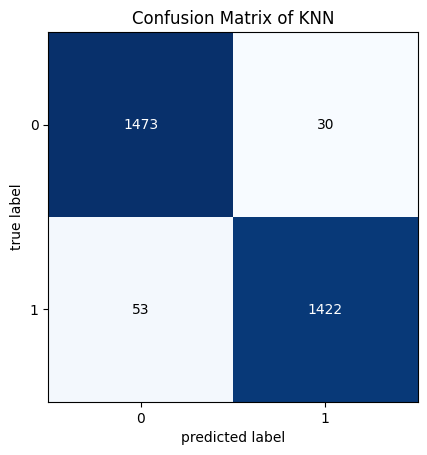

In [19]:
binary1 = np.array([[1473, 30],
                    [53, 1422]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.title("Confusion Matrix of KNN")
plt.show()

In [43]:
print("-------------Test Scores-----------")
print(tabulate([rfc_scores, dt_scores, lr_scores, knn_scores], headers=['S/N','Model', 'Accuracy', 'F1', 'Precision', 'Recall'], showindex=True))

-------------Test Scores-----------
  S/N  Model                  Accuracy        F1    Precision    Recall
-----  -------------------  ----------  --------  -----------  --------
    0  Random Forest          0.985897  0.985695     0.990418  0.981017
    1  Decision Tree          0.973808  0.973541     0.974202  0.972881
    2  Logistic Regression    0.892545  0.891746     0.889939  0.893559
    3  KNN                    0.964741  0.964029     0.974377  0.953898


In [44]:
print("-------------Train Scores-----------")
print(tabulate([rfc_train_scores, dt_train_scores, lr_train_scores, knn_train_scores], headers=['S/N','Model', 'Accuracy', 'F1', 'Precision', 'Recall'], showindex=True))

-------------Train Scores-----------
  S/N  Model                  Accuracy        F1    Precision    Recall
-----  -------------------  ----------  --------  -----------  --------
    0  Random Forest          1         1            1         1
    1  Decision Tree          1         1            1         1
    2  Logistic Regression    0.899673  0.896832     0.898305  0.895363
    3  KNN                    0.978591  0.977863     0.98496   0.970867


Based on the evaluation metrics, it was found that the Random Forest model performed the best among the four models. The Random Forest model achieved a higher metric score, indicating its superior performance in predicting and detecting cybersecurity threats compared to the other models.



In [45]:
import pickle
pickle.dump(rfc, open('model.pkl', 'wb'))

In [1]:
!pandoc latest.ipynb -s -o new_doc.docx

/bin/bash: line 1: pandoc: command not found
